In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
from read_data import *
from filter import *
from analysis import *
import matplotlib.pyplot as plt
import copy

In [113]:
class Epoch(object):    
    def __init__(self, names, time, currentTrace, nthEpoch = 0, piezo = None, commandVoltage = None, filter = None, fc = None):
        """
        Epoch objects hold all the information about an epoch and should be used to store raw and manipulated data
        
        Parameters (must be entered in this order):
            time - 1D array containing time (in seconds)
            currentTrace - 1D array containing the current trace
            piezo - 1D array containing the voltage applied to the Piezo device
            commandVoltage - 1D array containing voltage applied to cell
            nthMeasurement - the number of measurements on this cell that came 
                            before this one (integer)
            filter - type of filter used (string)
            fc - cutoff frequency of the filter (float)
        """
        self.time = time*1000 #convert from seconds to milliseconds
        self.currentTrace = currentTrace
        self.piezo = piezo
        self.commandVoltage = commandVoltage
        self.nthEpoch = nthEpoch
        self.names = names
        self.filterMethod = filter
        self.cutoffFrequency = fc
        self.baselineCorrected = False
        self.idealized = 'Note idealized'
    def plot_trace(self):
        fig = plt.figure(figsize = (20,5))
        plt.plot(self.time,self.currentTrace)
        plt.xlabel('time [ms]')
        plt.ylabel(self.names[0])
        plt.show()
    def plot_epoch(self, mode='full'):
        if mode == 'full':
            n = 3
            toPlot = [self.currentTrace, self.piezo, self.commandVoltage]
        elif mode == 'current':
            print("This does not work yet!")
#             n = 1
#             toPlot = [self.currentTrace]
            pass
        fig, ax = plt.subplots(n,1,figsize=(20,10),sharex=True)
        fig.suptitle('epoch #%.d'%(self.nthEpoch+1))
        end = np.min([len(self.currentTrace),len(self.time)])
        for i in range(n):
            ax[i].plot(self.time[:end],toPlot[i][:end])
            ax[i].set_ylabel(self.names[i])
        plt.setp(ax,xlabel='time [ms]')
        plt.show()

In [114]:
class Recording(object):
    def __init__(self, 
                 filename='170404 015.axgd',
                 filepath='/home/dpenguin/Documents/work/real data',
                 samplingrate=4e4,
                 filetype = 'axo',
                 headerlength = None,
                 bindtype = None,
                 *args,**kwars):
        
        self.filename = filename
        self.path = filepath
        self.samplingRate = samplingrate
        self.filetype = filetype
        self.headerlength = headerlength
        self.bindtype = bindtype

        self.data = {'raw':[]}       
        
#     def lookup_deco(f):
#         def do_lookup(dataKey, *args, **kwargs):
#             try:
#                 data = self.data[dataKey]
#             except KeyError:
#                 print("The data you're looking for does not exist")
#             f(data, *args, **kwargs)
#         return do_lookup(dataKey, *args, **kwargs)
        
    def load_data(self):
        """Load the raw data from binary of axograph file. All parameters are specified in the initialization of th Recording instance."""
        if self.filetype == 'axo':
            names, time, current, piezo, voltage = load_axo(self.path, self.filename)   
            self.data['raw'] = self.store_rawdata(names, time, current, piezo=piezo, commandVoltage = voltage)
        elif self.filetype == 'bin':
            names, time, current = load_binary(self.path, self.filename,self.bindtype,self.headerlength,self.samplingRate)
            self.data['raw'] = self.store_rawdata(names, time, current[np.newaxis])
        else:
            print("Filetype not supported.")
            
    def store_rawdata(self, names, time, current, piezo = None, commandVoltage = None):
        """
        Store the raw data in epoch objects
        """
        rawData = []
        for i in range(len(current)):
            if piezo is not None:
                epo = Epoch(names, time, current[i], nthEpoch=i, piezo=piezo[i], commandVoltage=commandVoltage[i])
            else:
                epo = Epoch(names, time, current[i], nthEpoch=i)
            rawData.append(epo)
        return rawData
            
    def filter_data(self, fc = 1e3, filter = 'Gaussian'):
        if filter == 'Gaussian':
            name = "G"
            fcs = fc/self.samplingRate #cutoff frequency in 1/samples
            filterWindow = Gaussian(fcs)
            filter_lag = int(1/(2*fcs))
            fData = []
            for epoch in self.data['raw']:
                filteredTrace = apply_filter(epoch.currentTrace, filterWindow)
                filteredEpoch = copy.deepcopy(epoch)
                filteredEpoch.currentTrace = filteredTrace[filter_lag:] 
                filteredEpoch.filterMethod = 'Gaussian'
                filteredEpoch.cutoffFrequency = fc
                fData.append(filteredEpoch)
            name = name+str(int(fc))+'Hz'
            self.data[name] = fData
            
    def baseline_correction(self, dataKey, interval, method='simple'):
        """
        Do baseline correction on each epoch.
        Parameters:
            interval - list containing the beginning and end points of the interval from the baseline is to be estimated (in milliseconds)
            dataKey - 
        """
        try: ###should write a decorator that does this!!!
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        if "_BC" in dataKey:
            print("Baseline correction has already been performed on these data.")
            pass
        corrected = []
        for epoch in data:
            correctedEpoch = copy.deepcopy(epoch)
            correctedEpoch.currentTrace = baseline(epoch.currentTrace, interval, self.samplingRate)
            correctedEpoch.baselineCorrected = True
            corrected.append(correctedEpoch)
        name = dataKey+"_BC"
        self.data[name] = corrected
    
    def idealization(self, dataKey, threshold = .5):
        if self.filetype is not 'bin':
            print("Can only idealize single level channels so far. (That means bin files)")
            pass
        try:
            data = self.data[dataKey]
        except KeyError:
            print("These data don't exist.")
            pass
        idealized = []
        for epoch in data:
            idealizedEpoch = copy.deepcopy(epoch)
            activity, signalmax = threshold_crossing(idealizedEpoch.currentTrace,threshold)
            idealizedEpoch.currentTrace = activity*signalmax
            idealizedEpoch.idealized = 'Idealized with simple threshold crossing'
            idealized.append(idealizedEpoch)
        name = dataKey + '_TC'
        self.data[name] = idealized

In [179]:
def multilevel_threshold(signal):
    signalmax = np.max(np.abs(signal))
    thetas = np.linspace(0,1,5)*signalmax
    idealization = np.zeros(len(signal))
#     print(thetas)
    for i in range(len(signal)):
#         print(np.abs(signal[i]))
        if thetas[0]<np.abs(signal[i])<thetas[1]:
            idealization[i] = 0
#             print(0)
        elif thetas[1]<np.abs(signal[i])<thetas[2]:
            idealization[i] = 1
#             print(1)
        elif thetas[2]<np.abs(signal[i])<thetas[3]:
            idealization[i] = 2
#             print(2)
        elif thetas[3]<np.abs(signal[i])<thetas[4]:
            idealization[i] = 3
#             print(3)
    return idealization, signalmax

In [138]:
rec = Recording()
rec.load_data()
rec.filter_data()
rec.baseline_correction('G1000Hz',[0,10])
rec.data['G1000Hz_BC']

In [187]:
signal = rec.data['G1000Hz_BC'][0].currentTrace[10:-50]
time = rac.data

In [188]:
ideal, sm = multilevel_threshold(signal)

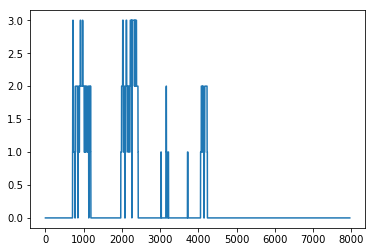

In [189]:
plt.plot(ideal)
plt.show()

In [190]:
sm, np.max(signal)

(3.259538437521484e-12, 3.3270003313922458e-13)

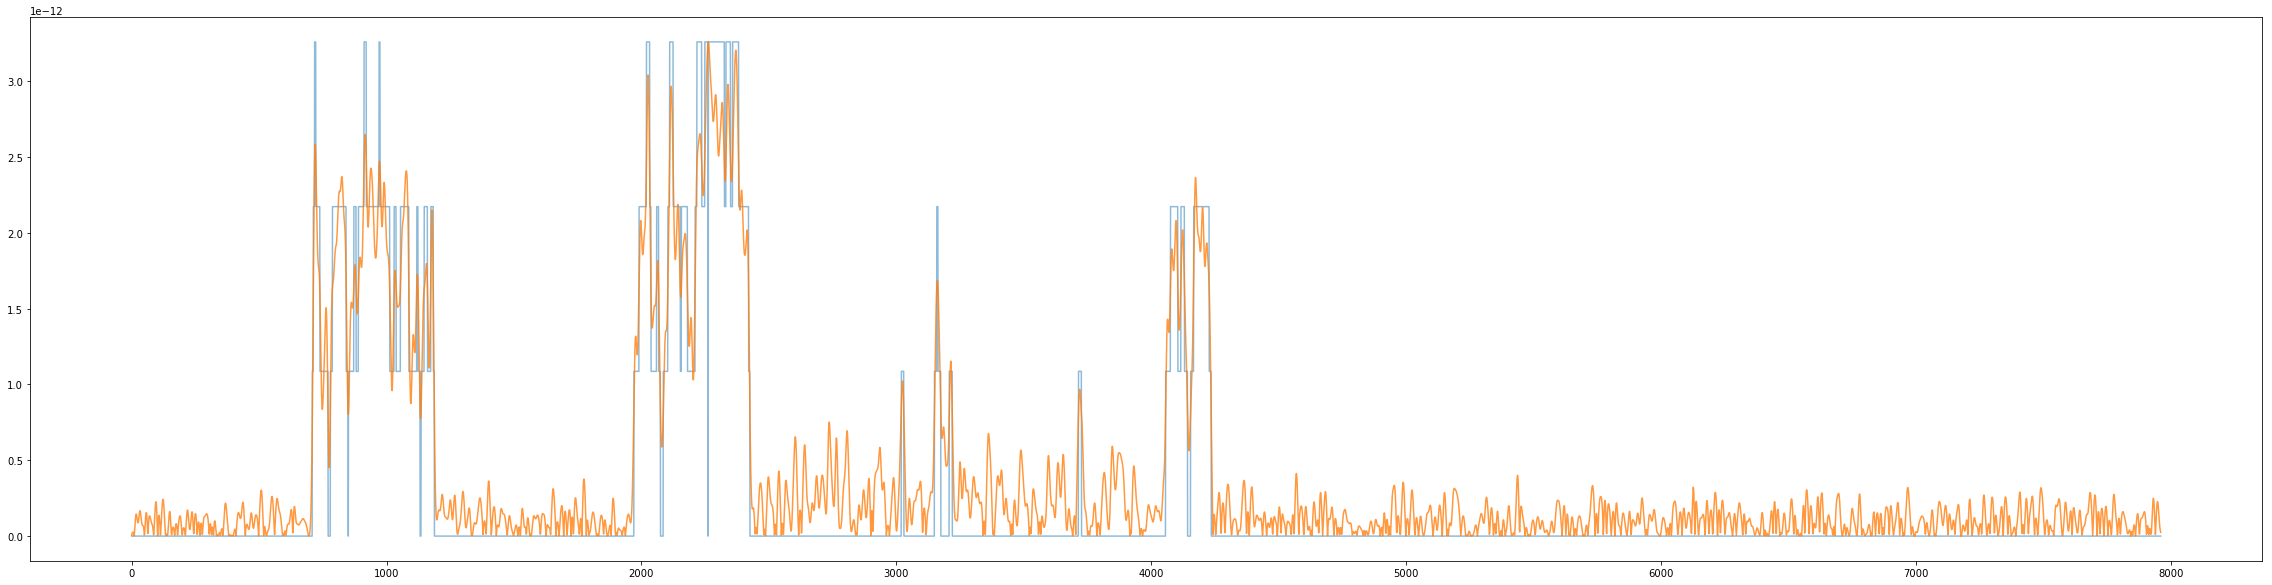

In [195]:
plt.figure(figsize=(40,10))
plt.plot(ideal*sm/3,alpha = .5)
plt.plot(np.abs(signal),alpha=.8)
plt.show()

In [115]:
bn = 'sim1600.bin'
bp = '/home/dpenguin/Documents/work/Code/detection'
bt = np.int16
bh = 3072
n, t, d = load_binary(bp,bn,bt,bh,4e4)

add noise to ideal, fitler as original signal then fit (minimize sum of pointsize differences)

In [116]:
rec = Recording(filename=bn,filepath=bp,filetype='bin',headerlength=bh,bindtype=bt)

In [117]:
rec.load_data()

In [121]:
rec.idealization('raw')

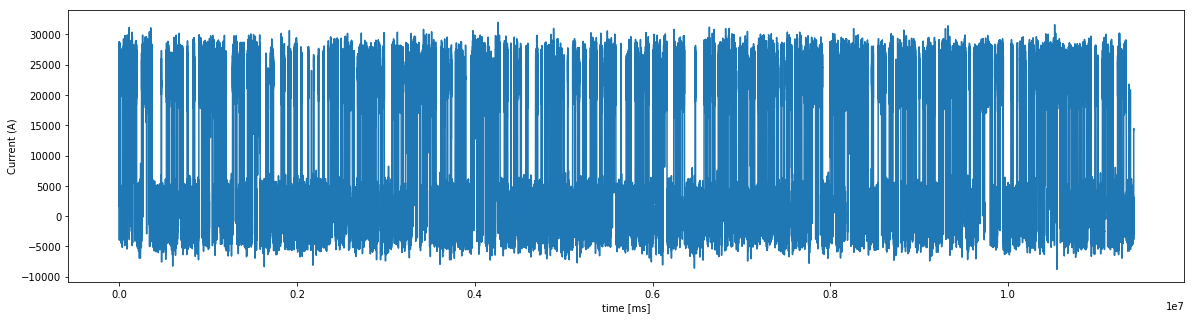

In [125]:
rec.data['raw'][0].plot_trace()

In [130]:
def visual_compare(recording, dataKey = 'raw', epochnumber = 0, tstart = 0, tend = 5000):
    fig = plt.figure(figsize=(20,8))
    time = recording.data[dataKey][epochnumber].time[tstart:tend]
    signal = recording.data[dataKey][epochnumber].currentTrace[tstart:tend]
    ideal = recording.data[dataKey+'_TC'][epochnumber].currentTrace[tstart:tend]
    plt.plot(time, signal, label='unfiltered data',alpha=.8)
    plt.plot(time, ideal, label='idealization', alpha =.7)
    plt.xlabel('time [ms]')
    plt.xticks(np.arange(tstart,tend))
    plt.ylabel('current [A]')
    plt.show()

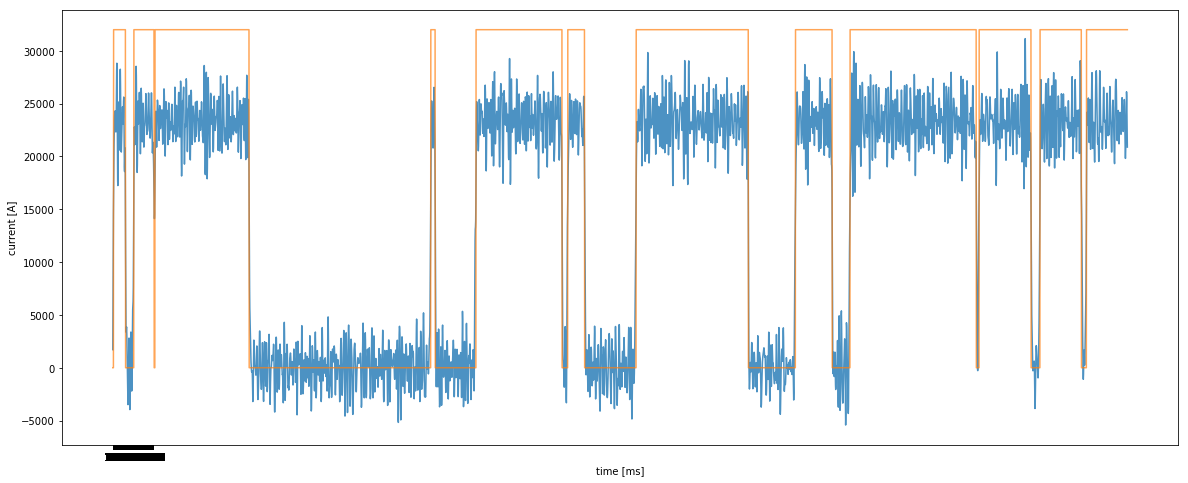

In [129]:
visual_compare(rec)

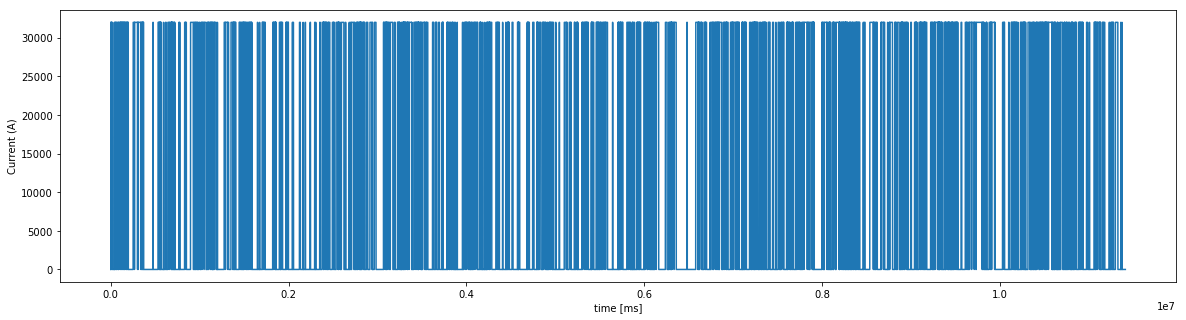

In [122]:
rec.data['raw_TC'][0].plot_trace()

In [112]:
rec.data['raw_TC'][0].names

['Current (A)']

In [107]:
rec.data['raw_TC']

In [94]:
for epo in rec.data['raw']:
    print(epo)

In [58]:
recaxo = Recording()

In [59]:
recaxo.load_data()

In [68]:
recaxo.filter_data()

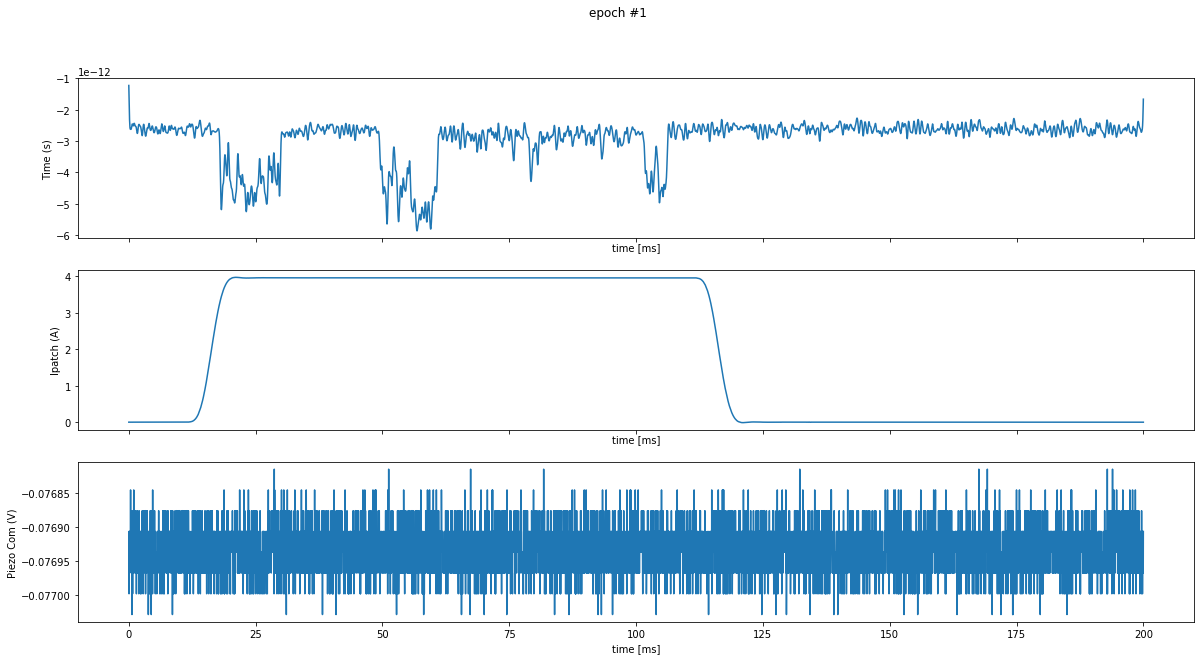

In [69]:
recaxo.data['G1000Hz'][0].plot_epoch()

In [64]:
rec.data.keys()

dict_keys(['raw'])

In [18]:
rec.filter_data()
rec.baseline_correction('G1000Hz',[0,10])

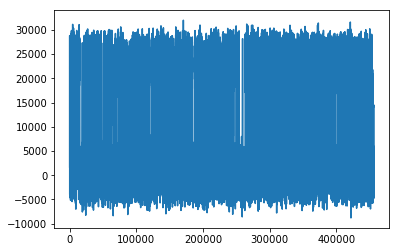

In [23]:
plt.plot(rec.data['raw'][0].currentTrace)
plt.show()

In [57]:
rec.data['G1000Hz']

[]